Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
--- Initializing Profile Database ---
Processing ipn profiles...
-> Added 2 profiles.

Database populated. Total profiles: 2

--- Setting up a 3D Building Frame Analysis ---

Successfully loaded profiles: 'IPE300' for columns, 'IPE240' for beams.

--- Generating Visualizations ---


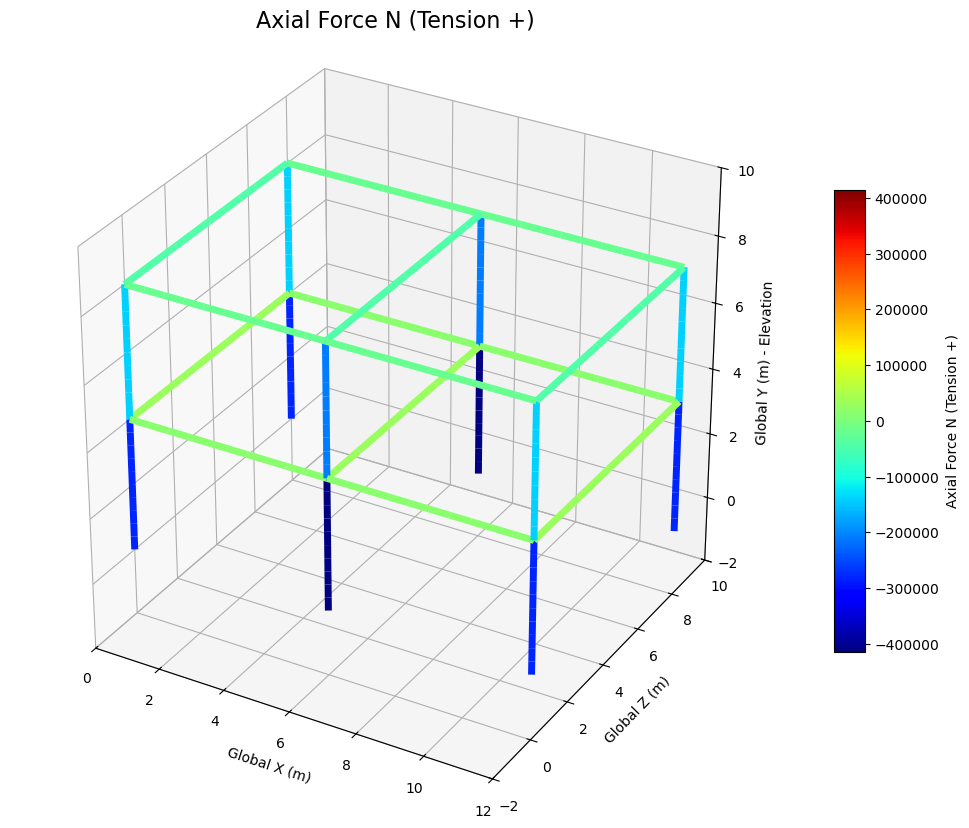

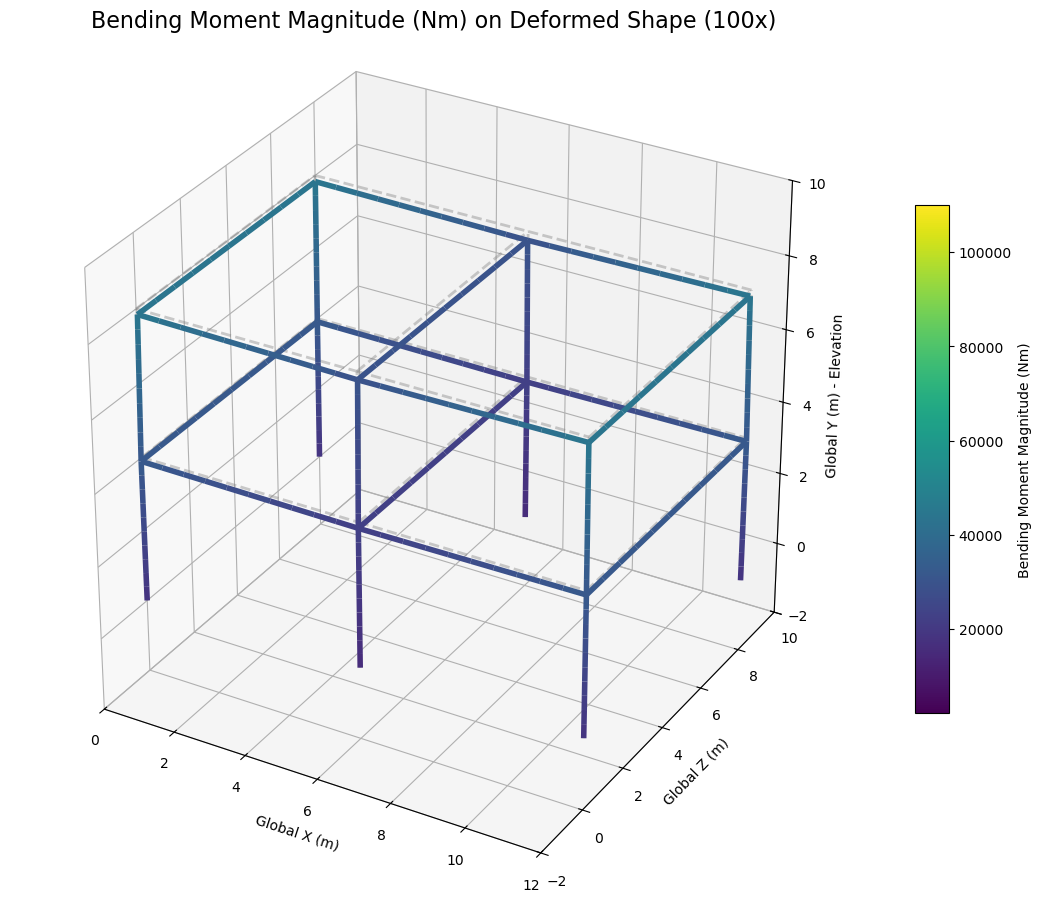

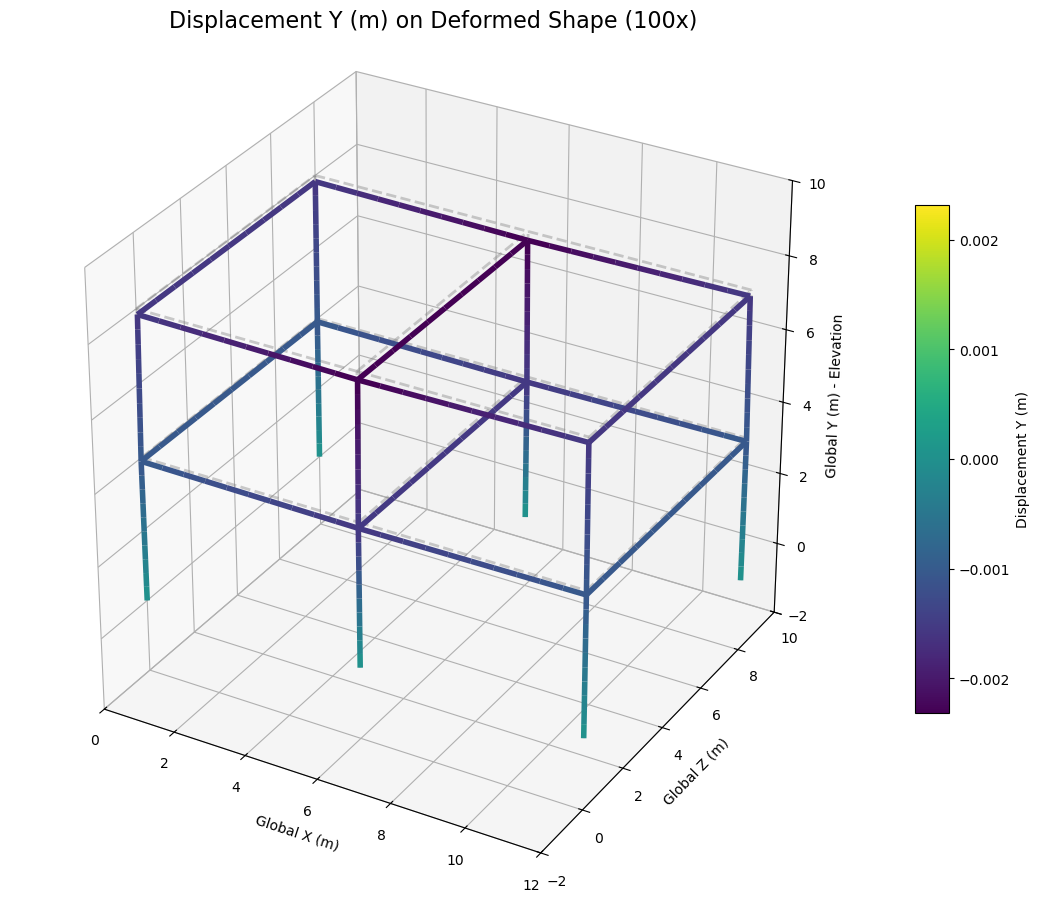

In [1]:
import numpy as np
import pandas as pd
from itertools import combinations
import pickle

# Import all necessary classes and modules
from structural_model import Node, Beam, Connection
from frame_analyzer import FrameAnalyzer
from visualizer import Visualizer
import profile_manager # Import our new module

def main():
    """
    Defines and analyzes a 3D building frame using profiles from a database,
    then visualizes the results.
    """
    # --- 1. SETUP THE DATABASE (Do this ONCE) ---
    print("--- Initializing Profile Database ---")

    # ==============================================================================
    with open('profiles.pkl', 'rb') as f:
        profiles = pickle.load(f)

    # --- Placeholder DataFrames (REPLACE WITH YOUR ACTUAL DATA) ---
    ipn_data = {
        'Designación': ['IPE240', 'IPE300'], 'Dimensiones d (m)': [0.240, 0.300],
        'bf (m)': [0.120, 0.150], 'Ag (m²)': [0.00391, 0.00538],
        'X-X Ix (m⁴)': [3.892e-5, 8.356e-5], 'Y-Y Iy (m⁴)': [2.836e-6, 6.038e-6],
        'J (m⁴)': [1.28e-7, 2.51e-7]
    }
    ipn_df = pd.DataFrame(ipn_data)
    # ==============================================================================


    # Create a dictionary of all your DataFrames
    # The keys ('ipn', 'upn', etc.) should match those in profile_manager
    all_dfs = {
        'ipn': ipn_df,
        # 'upn': upn_df,           # Uncomment and add your other DataFrames here
        # 'square': square_df,
        # 'rectangular': rectangular_df,
        # 'circular': circular_df,
        # 'l': l_df
    }

    # Populate the centralized database
    profile_manager.populate_database(all_dfs)


    # --- 2. DEFINE THE MODEL ---
    print("\n--- Setting up a 3D Building Frame Analysis ---")
    num_stories = 2
    story_height = 4.0
    bay_widths_x = [6.0, 6.0]
    bay_widths_z = [8.0]

    # Define material properties
    E_steel = 200e9
    nu_steel = 0.3
    rho_steel = 7850

    # --- Get beam and column properties from the database ---
    try:
        col_props = profile_manager.get_beam_properties('IPE300', E_steel, nu_steel, rho_steel)
        beam_props = profile_manager.get_beam_properties('IPE240', E_steel, nu_steel, rho_steel)
        print("\nSuccessfully loaded profiles: 'IPE300' for columns, 'IPE240' for beams.")
    except KeyError:
        print("A specified profile was not found. Please check profile names and that the correct DataFrame was loaded.")
        return # Exit if profiles aren't found


    # --- 3. GENERATE GEOMETRY AND ELEMENTS ---
    nodes, beams = [], []
    num_x_nodes = len(bay_widths_x) + 1
    num_z_nodes = len(bay_widths_z) + 1
    def get_node_index(story, x_idx, z_idx):
        return story * (num_x_nodes * num_z_nodes) + z_idx * num_x_nodes + x_idx

    x_coords = [0] + list(np.cumsum(bay_widths_x))
    z_coords = [0] + list(np.cumsum(bay_widths_z))
    for s in range(num_stories + 1):
        for z_idx, z in enumerate(z_coords):
            for x_idx, x in enumerate(x_coords):
                nodes.append(Node(x, s * story_height, z))

    beams_at_node = [[] for _ in range(len(nodes))]
    beam_idx_counter = 0
    # Generate Columns
    for s in range(num_stories):
        for z_idx in range(num_z_nodes):
            for x_idx in range(num_x_nodes):
                n1_idx, n2_idx = get_node_index(s, x_idx, z_idx), get_node_index(s + 1, x_idx, z_idx)
                beams.append(Beam(n1_idx, n2_idx, **col_props))
                beams_at_node[n1_idx].append(beam_idx_counter); beams_at_node[n2_idx].append(beam_idx_counter)
                beam_idx_counter += 1
    # Generate horizontal beams
    for s in range(1, num_stories + 1):
        for z_idx in range(num_z_nodes):
            for x_idx in range(num_x_nodes - 1):
                n1_idx, n2_idx = get_node_index(s, x_idx, z_idx), get_node_index(s, x_idx + 1, z_idx)
                beams.append(Beam(n1_idx, n2_idx, **beam_props))
                beams_at_node[n1_idx].append(beam_idx_counter); beams_at_node[n2_idx].append(beam_idx_counter)
                beam_idx_counter += 1
        for x_idx in range(num_x_nodes):
            for z_idx in range(num_z_nodes - 1):
                n1_idx, n2_idx = get_node_index(s, x_idx, z_idx), get_node_index(s, x_idx, z_idx + 1)
                beams.append(Beam(n1_idx, n2_idx, **beam_props))
                beams_at_node[n1_idx].append(beam_idx_counter); beams_at_node[n2_idx].append(beam_idx_counter)
                beam_idx_counter += 1

    connections = []
    for node_beams in beams_at_node:
        if len(node_beams) > 1:
            for b1, b2 in combinations(node_beams, 2):
                connections.append(Connection(b1, b2, 'rigid'))

    # --- 4. DEFINE LOADS & BCs ---
    loads = []
    q_gravity_magnitude = -20e3
    g = -9.81
    global_load_direction = np.array([0, -1, 0])
    temp_analyzer = FrameAnalyzer(nodes, beams, connections)
    for beam_idx, beam in enumerate(beams):
        temp_analyzer._compute_beam_properties(beam)
        q_mag_sw = beam.rho * g * beam.A
        q_local_dir_sw = beam.rotation_matrix @ global_load_direction
        loads.append({'beam_idx': beam_idx, 'qy': q_mag_sw * q_local_dir_sw[1], 'qz': q_mag_sw * q_local_dir_sw[2]})

        n1, n2 = nodes[beam.node1_idx], nodes[beam.node2_idx]
        is_floor_beam = abs(n1.y - n2.y) < 1e-6 and n1.y > 0
        if is_floor_beam:
            q_local_dir_imposed = beam.rotation_matrix @ global_load_direction
            loads.append({'beam_idx': beam_idx, 'qy': q_gravity_magnitude * q_local_dir_imposed[1], 'qz': q_gravity_magnitude * q_local_dir_imposed[2]})

    boundary_conditions = []
    for node_idx in range(num_x_nodes * num_z_nodes):
        boundary_conditions.append({'node_idx': node_idx, 'u':0,'v':0,'w':0,'theta_x':0,'theta_y':0,'theta_z':0})

    # --- 5. RUN ANALYSIS & VISUALIZE ---
    analyzer = FrameAnalyzer(nodes, beams, connections)
    if not analyzer.solve(loads, boundary_conditions):
        print("Analysis failed. Exiting.")
        return

    print("\n--- Generating Visualizations ---")
    visualizer = Visualizer(analyzer)
    visualizer.plot(result_type='axial_force')
    visualizer.plot_deformed_shape(result_type='moment_mag', amplification_factor=100)
    visualizer.plot_deformed_shape(result_type='disp_y', amplification_factor=100)


if __name__ == "__main__":
    main()

--- Initializing Profile Database ---
Successfully loaded profile DataFrames from 'profiles.pkl'.
Processing IPN profiles...
-> Added 380 profiles.
Processing Square profiles...
-> Added 89 profiles.
Processing Rectangular profiles...
-> Added 95 profiles.
Processing Circular profiles...
-> Added 168 profiles.
Processing L profiles...
-> Added 47 profiles.
Processing UPN profiles...
-> Added 17 profiles.

Database populated. Total profiles: 796

--- Building Composite Cantilever Beam ---

Created 7 nodes for 6 segments.

Creating Segment 1 with Profile: CIRC1828.8X19.05
Loaded Properties:
{'A': 0.108309,
 'E': 200000000000.0,
 'Iy': 0.04434609,
 'Iz': 0.04434609,
 'J': 0.08869218,
 'cy': 0.9144,
 'cz': 0.9144,
 'nu': 0.3,
 'rho': 7850}

Creating Segment 2 with Profile: CIRC1828.8X19.05
Loaded Properties:
{'A': 0.108309,
 'E': 200000000000.0,
 'Iy': 0.04434609,
 'Iz': 0.04434609,
 'J': 0.08869218,
 'cy': 0.9144,
 'cz': 0.9144,
 'nu': 0.3,
 'rho': 7850}

Creating Segment 3 with Profile: 

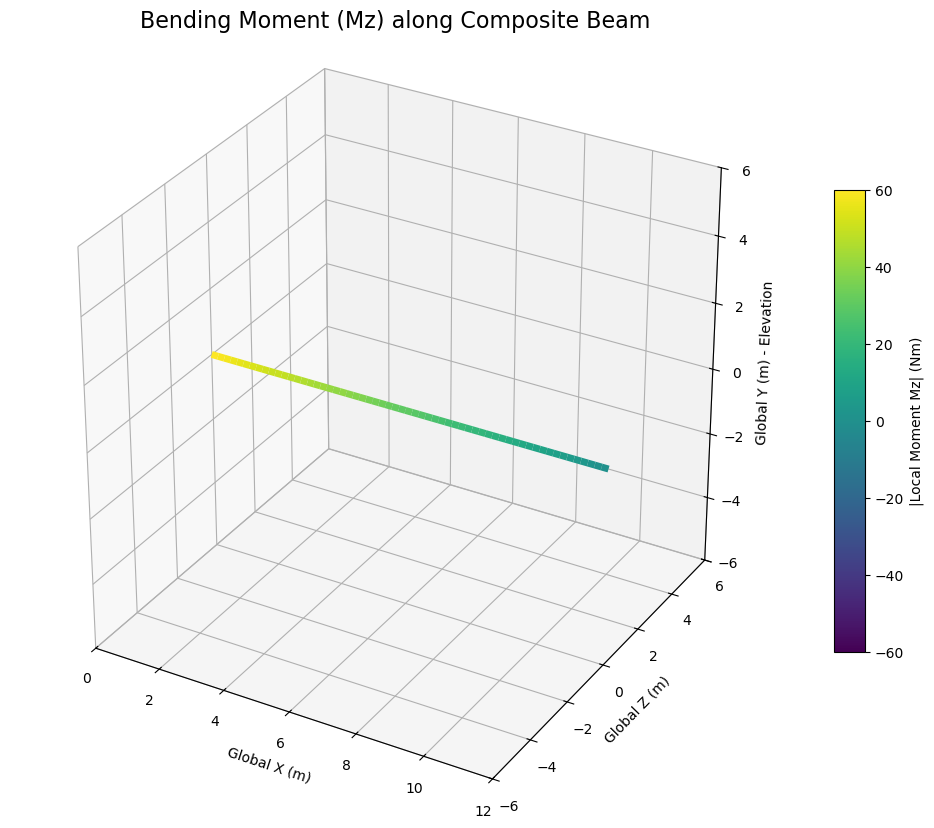

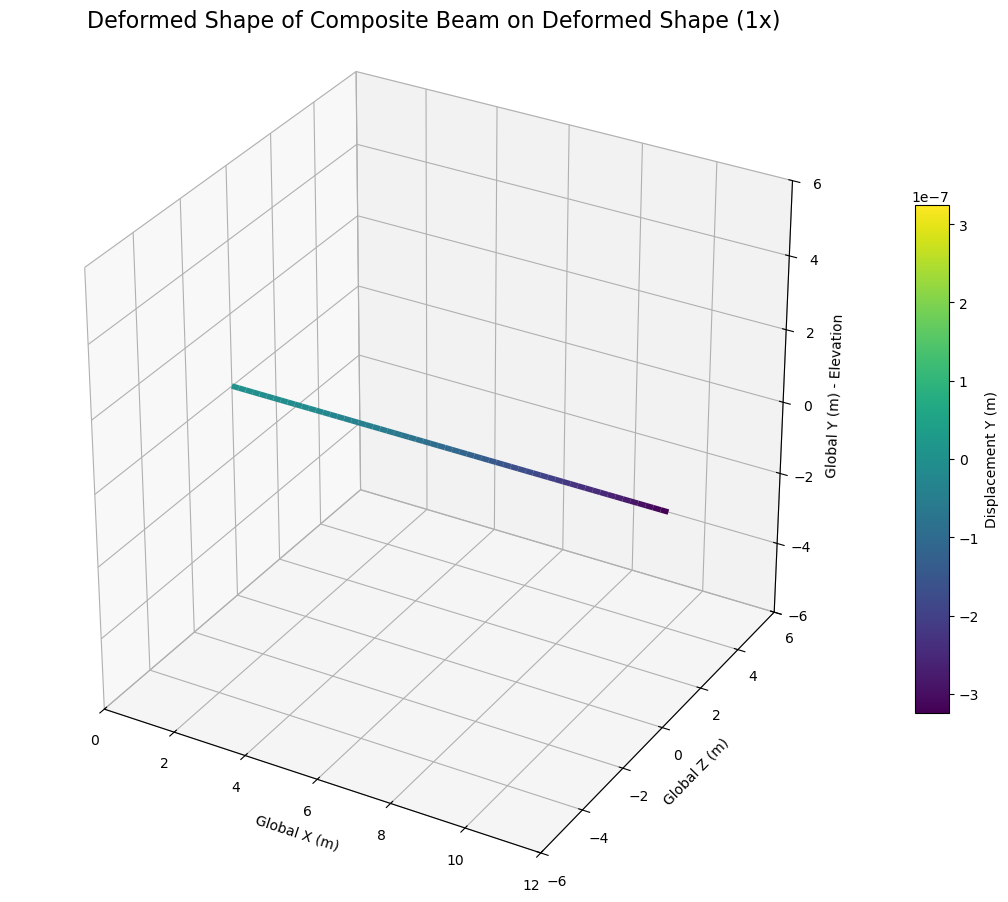

------------------------------------------------------------



In [16]:
# main_test_suite_oriented.py

import numpy as np
import pandas as pd
import pickle # For loading the dataframe dictionary
import pprint # For nicely formatted dictionary printing
from itertools import combinations

# Import all necessary classes and modules
from structural_model import Node, Beam, Connection
from frame_analyzer import FrameAnalyzer
from visualizer import Visualizer
import profile_manager # Our profile processing module

def main():
    """
    Initializes the profile database and runs a single analysis of a composite
    cantilever beam built from multiple profile types, with each profile
    oriented for maximum strength against gravity loads.
    """
    # --- 1. SETUP THE DATABASE ---
    print("--- Initializing Profile Database ---")
    try:
        with open('profiles.pkl', 'rb') as f:
            all_dfs = pickle.load(f)
        print("Successfully loaded profile DataFrames from 'profiles.pkl'.")
    except FileNotFoundError:
        print("ERROR: 'profiles.pkl' not found. Please ensure the file is in the correct directory.")
        return
    except Exception as e:
        print(f"An error occurred while loading 'profiles.pkl': {e}")
        return

    profile_manager.populate_database(all_dfs)

    # --- 2. DEFINE THE COMPOSITE BEAM ---
    print("\n" + "="*60)
    print("--- Building Composite Cantilever Beam ---")

    # List of profiles to use for each segment of the beam
    test_profiles = [
        'IPE240',           # Segment 1
        'UPN120',           # Segment 2
        'CUAD50X2',         # Segment 3
        'REC10X20X0.9',     # Segment 4
        'CIRC1828.8X19.05', # Segment 5
        'L25X25X3.2'        # Segment 6
    ]

    # Define material properties
    E_steel = 200e9
    nu_steel = 0.3
    rho_steel = 7850

    segment_length = 2.0  # Increased length for better visualization
    nodes = []
    beams = []

    # Create nodes in a line along the X-axis
    for i in range(len(test_profiles) + 1):
        nodes.append(Node(i * segment_length, 0, 0))

    print(f"\nCreated {len(nodes)} nodes for {len(test_profiles)} segments.")

    # Create beam segments, each with a different profile
    for i, profile_name in enumerate(test_profiles):
        print(f"\nCreating Segment {i+1} with Profile: {profile_name}")
        try:
            # Get properties from the database
            props = profile_manager.get_beam_properties(profile_name, E_steel, nu_steel, rho_steel)
            print("Loaded Properties:")
            pprint.pprint(props)

            # --- THIS IS THE CHANGE ---
            # Define a reference vector to orient the beam for maximum strength.
            # For a horizontal beam under gravity load (Fy), we want the beam's
            # local y-axis (web direction for an I-beam) to align with the global Y-axis.
            # Providing a ref_vector along the global Z-axis achieves this.
            orientation_vector = np.array([0, 0, 1])

            # Create the beam element with the specified properties and orientation
            beams.append(Beam(i, i+1, **props, ref_vector=orientation_vector))

        except KeyError:
            print(f"---> SKIPPING SEGMENT: Profile '{profile_name}' not found in the database.")
            continue

    # --- 3. DEFINE CONNECTIONS, LOADS, & BCS ---
    connections = []
    for i in range(len(beams) - 1):
        connections.append(Connection(beam1_idx=i, beam2_idx=i+1, conn_type='rigid'))
    print(f"\nCreated {len(connections)} rigid connections between segments.")

    tip_node_idx = len(nodes) - 1
    loads = [{'node_idx': tip_node_idx, 'Fy': -5}]
    boundary_conditions = [{'node_idx': 0, 'u':0, 'v':0, 'w':0, 'theta_x':0, 'theta_y':0, 'theta_z':0}]

    # --- 4. RUN ANALYSIS & VISUALIZE ---
    print("\n" + "="*60)
    print("--- Running Analysis on Composite Beam ---")
    analyzer = FrameAnalyzer(nodes, beams, connections)

    if analyzer.solve(loads, boundary_conditions):
        print("\nAnalysis successful.")
        tip_displacement_y = analyzer._displacements[nodes[tip_node_idx].dof_indices[1]]
        print(f"Result: Tip displacement in Y = {tip_displacement_y * 1000:.4f} mm")

        print("Generating visualizations...")
        try:
            visualizer = Visualizer(analyzer)
            visualizer.plot(result_type='moment_z', title="Bending Moment (Mz) along Composite Beam")
            visualizer.plot_deformed_shape(result_type='disp_y', amplification_factor=1, title="Deformed Shape of Composite Beam")
        except Exception as e:
            print(f"An error occurred during visualization: {e}")

    else:
        print("Analysis failed.")
    print("-" * 60 + "\n")


if __name__ == "__main__":
    main()

--- Initializing Profile Database ---
Successfully loaded profile DataFrames.
Processing IPN profiles...
-> Added 380 profiles.
Processing Square profiles...
-> Added 89 profiles.
Processing Rectangular profiles...
-> Added 95 profiles.
Processing Circular profiles...
-> Added 168 profiles.
Processing L profiles...
-> Added 47 profiles.
Processing UPN profiles...
-> Added 17 profiles.

Database populated. Total profiles: 796
Created 7 nodes and 6 beam segments.

Creating Segment 1 – Profile IPE240
{'A': 0.00391,
 'E': 200000000000.0,
 'Iy': 2.84e-06,
 'Iz': 3.8900000000000004e-05,
 'J': 9.28e-08,
 'cy': 0.12,
 'cz': 0.06,
 'nu': 0.3,
 'rho': 7850}

Creating Segment 2 – Profile UPN120
{'A': 0.0017000000000000001,
 'E': 200000000000.0,
 'Iy': 4.3200000000000006e-07,
 'Iz': 3.64e-06,
 'J': 3.84e-08,
 'cy': 0.06,
 'cz': 0.0275,
 'nu': 0.3,
 'rho': 7850}

Creating Segment 3 – Profile CUAD50X2
{'A': 0.00037370000000000003,
 'E': 200000000000.0,
 'Iy': 1.4137e-07,
 'Iz': 1.4137e-07,
 'J': 2.1

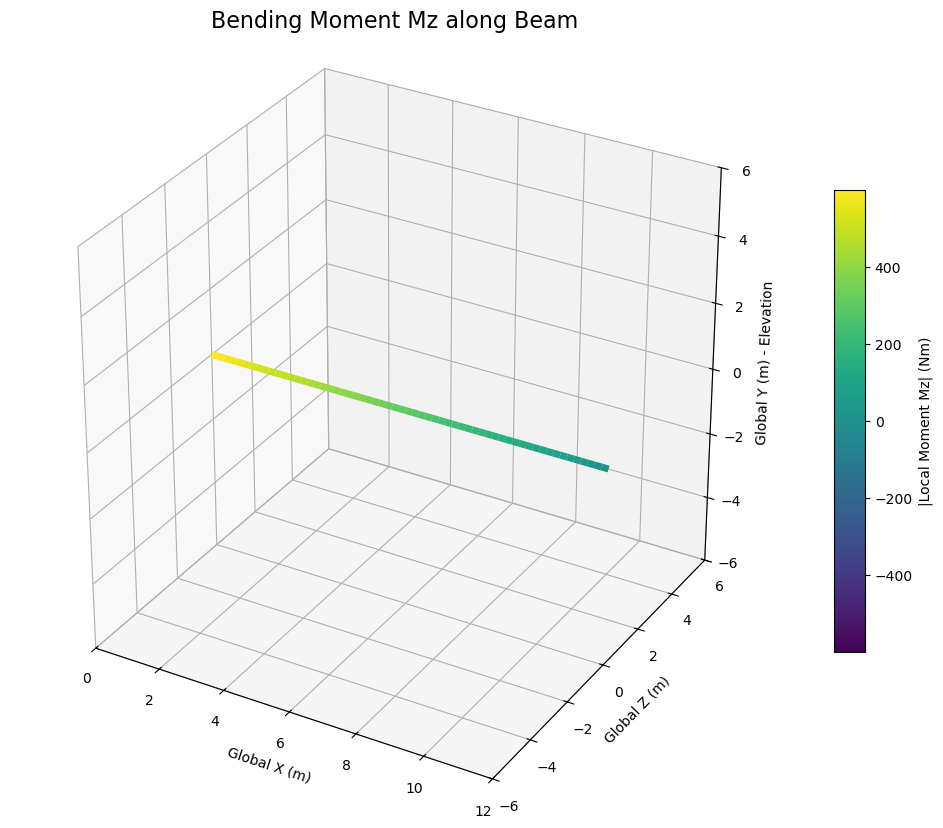

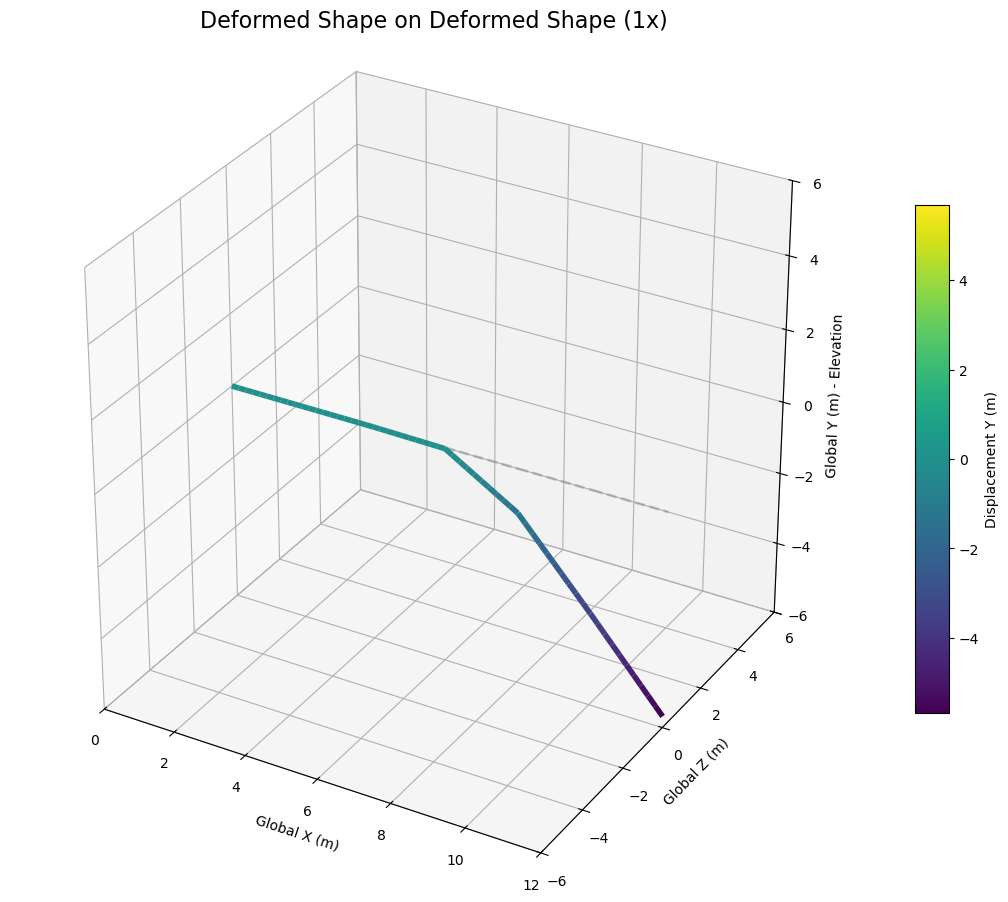


--- Verifying Members to AISC 360-22 (LRFD) ---

Unity-check summary (governing ratio per member):

 beam_idx          profile  governing_uc  PASS
        0           IPE240      0.005580  True
        1           UPN120      0.032887  True
        2         CUAD50X2      0.208729  True
        3     REC10X20X0.9      3.550470 False
        4 CIRC1828.8X19.05      0.000018  True
        5       L25X25X3.2      1.304121 False

*** MEMBERS THAT FAIL LRFD CHECKS ***

 beam_idx      profile  governing_uc governing_limitstate
        3 REC10X20X0.9      3.550470                   Mx
        5   L25X25X3.2      1.304121                   Mx


In [4]:
# main_test_suite_oriented.py
# ---------------------------------------------------------------
# Composite cantilever test + AISC-360-22 verification
# ---------------------------------------------------------------

import numpy as np
import pandas as pd
import pickle
import pprint

# Project-specific modules
from structural_model import Node, Beam, Connection
from frame_analyzer import FrameAnalyzer
from visualizer import Visualizer
import profile_manager                      # fills the DB
from aisc360_verifier import AISC360Verifier  # <-- NEW

# ---------------------------------------------------------------
def main() -> None:
    """
    Build a six-segment composite cantilever, run the FE analysis,
    then verify every segment per ANSI/AISC 360-22 and print a pass/fail
    table of unity checks.
    """

    # -------- 1. LOAD PROFILE DATABASE ---------------------------------
    print("--- Initializing Profile Database ---")
    try:
        with open("profiles.pkl", "rb") as f:
            all_dfs = pickle.load(f)        # Dict[str, pd.DataFrame]
        print("Successfully loaded profile DataFrames.")
    except Exception as exc:
        print(f"ERROR: cannot load 'profiles.pkl' – {exc}")
        return

    profile_manager.populate_database(all_dfs)   # your existing helper

    # -------- 2. BUILD GEOMETRY ----------------------------------------
    test_profiles = [
        "IPE240",            # Segment 1  (I-beam)
        "UPN120",            # Segment 2  (channel)
        "CUAD50X2",          # Segment 3  (square HSS)
        "REC10X20X0.9",      # Segment 4  (rect HSS)
        "CIRC1828.8X19.05",  # Segment 5  (round HSS)
        "L25X25X3.2"         # Segment 6  (angle)
    ]

    E_steel, nu_steel, rho_steel = 200e9, 0.30, 7850
    segment_L = 2.0
    nodes, beams = [], []

    # Node line (X-axis)
    for i in range(len(test_profiles) + 1):
        nodes.append(Node(i * segment_L, 0.0, 0.0))

    print(f"Created {len(nodes)} nodes and {len(test_profiles)} beam segments.")

    # Beam elements, each with its own rolled shape
    for i, prof in enumerate(test_profiles):
        print(f"\nCreating Segment {i+1} – Profile {prof}")
        try:
            props = profile_manager.get_beam_properties(
                prof, E_steel, nu_steel, rho_steel
            )
            pprint.pprint(props)

            # orient local y-axis vertically (global Y) → ref_vector = Z
            ref_vec = np.array([0.0, 0.0, 1.0])

            beam = Beam(i, i + 1, **props, ref_vector=ref_vec)
            beam.profile_name = prof.upper()        # <- used by verifier
            beams.append(beam)

        except KeyError:
            print(f"!! Profile '{prof}' not found – skipping this segment.")
            continue

    # -------- 3. CONNECTIONS & LOADING ---------------------------------
    connections = [
        Connection(beam1_idx=i, beam2_idx=i + 1, conn_type="rigid")
        for i in range(len(beams) - 1)
    ]
    tip_idx = len(nodes) - 1
    loads = [{"node_idx": tip_idx, "Fy": -50.0}]       # 5 kN downward
    bcs   = [{"node_idx": 0, "u":0, "v":0, "w":0,
              "theta_x":0, "theta_y":0, "theta_z":0}]

    # -------- 4. ANALYSIS ----------------------------------------------
    print("\n" + "=" * 60)
    print("--- Running FE Analysis ---")
    analyzer = FrameAnalyzer(nodes, beams, connections)

    if not analyzer.solve(loads, bcs):
        print("Analysis failed – aborting verification")
        return

    print("Analysis successful.")
    disp_y = analyzer._displacements[nodes[tip_idx].dof_indices[1]]
    print(f"Tip Y-displacement : {disp_y*1e3:.3f} mm")

    # -------- 5. VISUALISATION (optional) ------------------------------
    try:
        vis = Visualizer(analyzer)
        vis.plot(result_type="moment_z",
                 title="Bending Moment Mz along Beam")
        vis.plot_deformed_shape(result_type="disp_y",
                                amplification_factor=1,
                                title="Deformed Shape")
    except Exception as exc:
        print(f"Visualisation error: {exc}")

    # -------- 6. AISC-360-22 VERIFICATION ------------------------------
    print("\n" + "=" * 60)
    print("--- Verifying Members to AISC 360-22 (LRFD) ---")

    verifier = AISC360Verifier(
        analyzer      = analyzer,
        raw_profiles  = all_dfs,
        Fy            = 355e6,    # yield strength (MPa → Pa)
        Fu            = 490e6,    # ultimate
        design_method = "LRFD"
    )

    uc_table = verifier.run()          # pandas DataFrame
    pd.set_option("display.max_columns", None)
    print("\nUnity-check summary (governing ratio per member):\n")
    print(
        uc_table[["beam_idx", "profile", "governing_uc", "PASS"]]
        .to_string(index=False)
    )

    failed = uc_table[~uc_table["PASS"]]
    if not failed.empty:
        print("\n*** MEMBERS THAT FAIL LRFD CHECKS ***\n")
        print(failed[["beam_idx", "profile",
                      "governing_uc", "governing_limitstate"]]
              .to_string(index=False))
    else:
        print("\nAll members satisfy AISC 360-22 LRFD requirements.")

# ---------------------------------------------------------------
if __name__ == "__main__":
    main()


--- Loading profile DataFrames ---
Processing IPN profiles...
-> Added 380 profiles.
Processing Square profiles...
-> Added 89 profiles.
Processing Rectangular profiles...
-> Added 95 profiles.
Processing Circular profiles...
-> Added 168 profiles.
Processing L profiles...
-> Added 47 profiles.
Processing UPN profiles...
-> Added 17 profiles.

Database populated. Total profiles: 796
    beam_idx profile  governing_uc   PASS
0          0  IPE300      0.617184   True
1          1  IPE300      0.617184   True
2          2  IPE300      0.617184   True
3          3  IPE300      0.617184   True
4          4  IPE300      0.617184   True
5          5  IPE300      0.617184   True
6          6  IPE300      2.833682  False
7          7  IPE300      2.833682  False
8          8  IPE300      2.833682  False
9          9  IPE300      2.833682  False
10        10  IPE300      2.833682  False
11        11  IPE300      2.833682  False
12        12  IPE240      0.011810   True
13        13  IPE240      

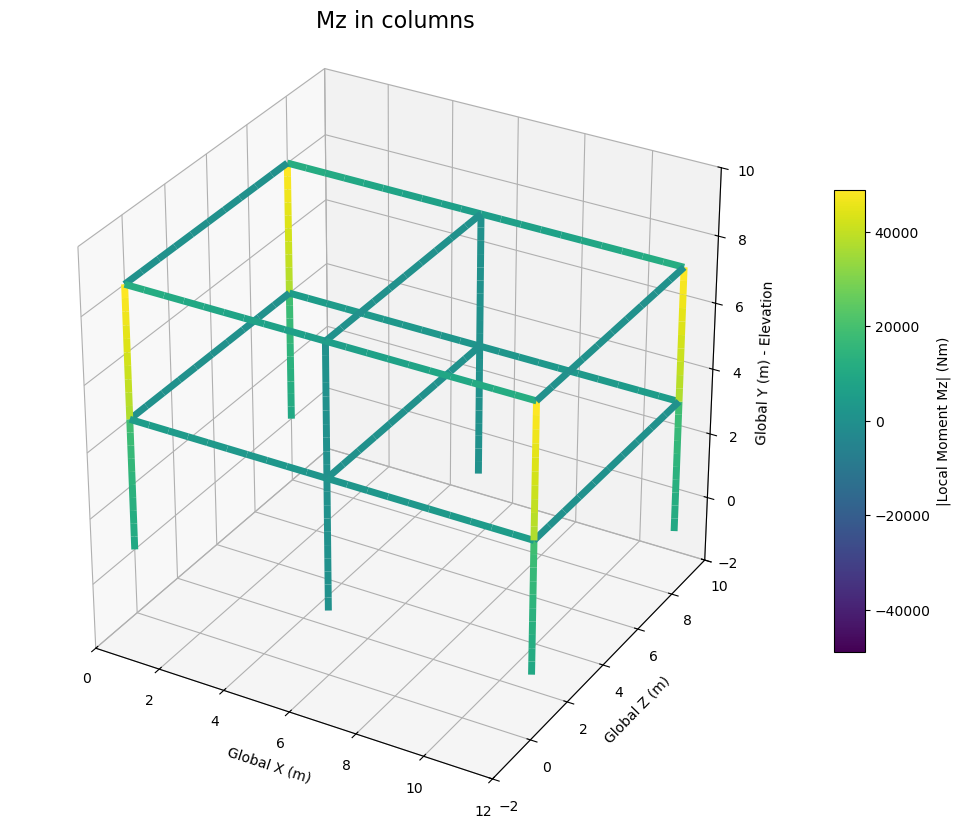

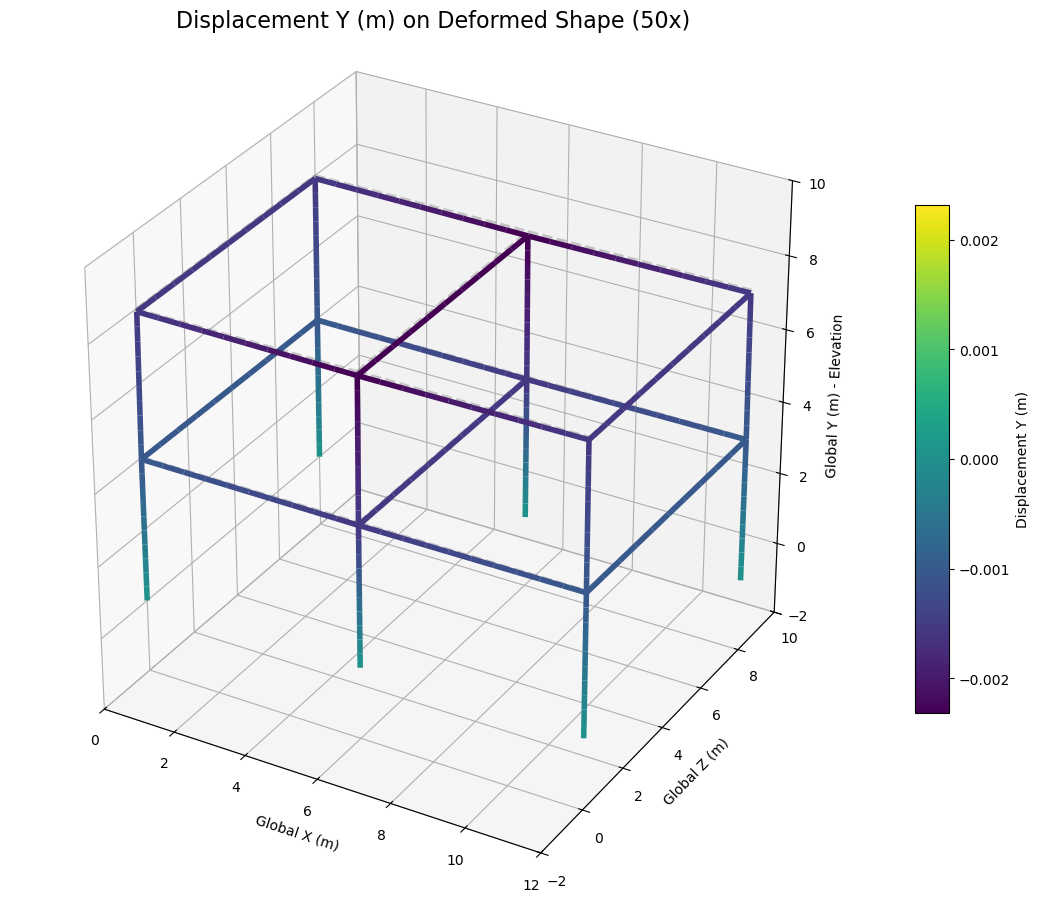

In [2]:
"""
full_structure_with_verification.py
2-story, two-bay-by-one-bay steel frame.
–  FE analysis with self-weight + imposed floor load
–  AISC-360-22 member checks
"""

import numpy as np
import pickle
from itertools import combinations

from structural_model import Node, Beam, Connection
from frame_analyzer import FrameAnalyzer
from visualizer import Visualizer
import profile_manager
from aisc360_verifier import AISC360Verifier

# ---------------------------------------------------------------------------
def main() -> None:

    # 1.  Database ---------------------------------------------------------
    print("--- Loading profile DataFrames ---")
    with open("profiles.pkl", "rb") as f:
        all_dfs = pickle.load(f)

    profile_manager.populate_database(all_dfs)

    # choose shapes that actually exist in your DB
    column_shape = "IPE300"
    beam_shape   = "IPE240"

    E, nu, rho = 200e9, 0.30, 7850
    col_props  = profile_manager.get_beam_properties(column_shape, E, nu, rho)
    beam_props = profile_manager.get_beam_properties(beam_shape,   E, nu, rho)

    # 2.  Geometry ---------------------------------------------------------
    n_stories, h_story = 2, 4.0
    bays_x = [6.0, 6.0]
    bays_z = [8.0]

    nx, nz = len(bays_x) + 1, len(bays_z) + 1
    x_pts  = [0.0] + list(np.cumsum(bays_x))
    z_pts  = [0.0] + list(np.cumsum(bays_z))

    def nid(s, ix, iz):         # node id helper
        return s * (nx * nz) + iz * nx + ix

    nodes = [Node(x, s * h_story, z)
             for s in range(n_stories + 1)
             for iz, z in enumerate(z_pts)
             for ix, x in enumerate(x_pts)]

    beams, attach = [], [[] for _ in range(len(nodes))]
    bidx = 0

    # columns
    for s in range(n_stories):
        for iz in range(nz):
            for ix in range(nx):
                n1, n2 = nid(s, ix, iz), nid(s + 1, ix, iz)
                beam   = Beam(n1, n2, **col_props)
                beam.profile_name = column_shape
                beams.append(beam)
                attach[n1].append(bidx); attach[n2].append(bidx); bidx += 1

    # floor beams (X & Z)
    for s in range(1, n_stories + 1):
        # X direction
        for iz in range(nz):
            for ix in range(nx - 1):
                n1, n2 = nid(s, ix, iz), nid(s, ix + 1, iz)
                beam   = Beam(n1, n2, **beam_props)
                beam.profile_name = beam_shape
                beams.append(beam)
                attach[n1].append(bidx); attach[n2].append(bidx); bidx += 1
        # Z direction
        for ix in range(nx):
            for iz in range(nz - 1):
                n1, n2 = nid(s, ix, iz), nid(s, ix, iz + 1)
                beam   = Beam(n1, n2, **beam_props)
                beam.profile_name = beam_shape
                beams.append(beam)
                attach[n1].append(bidx); attach[n2].append(bidx); bidx += 1

    # rigid joints at every node
    conns = [Connection(b1, b2, "rigid")
             for beams_here in attach if len(beams_here) > 1
             for b1, b2 in combinations(beams_here, 2)]

    # 3.  Loads ------------------------------------------------------------
    g_vec = np.array([0, -1, 0])
    imposed_load = -20e3             # N/m
    g_accel      = -9.81

    temp = FrameAnalyzer(nodes, beams, conns)
    loads = []
    for k, bm in enumerate(beams):
        temp._compute_beam_properties(bm)
        sw_per_m = bm.rho * g_accel * bm.A
        dir_sw   = bm.rotation_matrix @ g_vec
        loads.append({"beam_idx": k, "qy": sw_per_m * dir_sw[1],
                                  "qz": sw_per_m * dir_sw[2]})

        # imposed load on floor beams
        n1, n2 = nodes[bm.node1_idx], nodes[bm.node2_idx]
        if abs(n1.y - n2.y) < 1e-6 and n1.y > 0.0:
            dir_imp = dir_sw
            loads.append({"beam_idx": k, "qy": imposed_load * dir_imp[1],
                                      "qz": imposed_load * dir_imp[2]})

    # 4.  Supports & analysis ---------------------------------------------
    base_bcs = [{"node_idx": i,
                 "u":0,"v":0,"w":0,"theta_x":0,"theta_y":0,"theta_z":0}
                for i in range(nx * nz)]

    analyzer = FrameAnalyzer(nodes, beams, conns)
    analyzer.solve(loads, base_bcs)

    # 5.  Verification -----------------------------------------------------
    verifier = AISC360Verifier(analyzer=analyzer,
                               raw_profiles=all_dfs,
                               Fy=355e6, Fu=490e6,
                               design_method="LRFD")
    ucs = verifier.run()
    print(ucs[["beam_idx", "profile", "governing_uc", "PASS"]])

    if not ucs["PASS"].all():
        print("\n*** MEMBERS THAT FAIL ***")
        print(ucs.loc[~ucs["PASS"], ["beam_idx",
                                     "profile",
                                     "governing_uc",
                                     "governing_limitstate"]])

    # 6.  Optional plots ---------------------------------------------------
    vis = Visualizer(analyzer)
    vis.plot(result_type="moment_z", title="Mz in columns")
    vis.plot_deformed_shape(result_type="disp_y", amplification_factor=50)

# ---------------------------------------------------------------------------
if __name__ == "__main__":
    main()


Processing IPN profiles...
-> Added 380 profiles.
Processing Square profiles...
-> Added 89 profiles.
Processing Rectangular profiles...
-> Added 95 profiles.
Processing Circular profiles...
-> Added 168 profiles.
Processing L profiles...
-> Added 47 profiles.
Processing UPN profiles...
-> Added 17 profiles.

Database populated. Total profiles: 796
⇢  Evaluating 900 combinations

C/IPN80      B/IPN80      UC=10.99 ✗ +9.99 
C/IPN80      B/IPE80      UC=10.35 ✗ +9.35 
C/IPN80      B/IPE100     UC=9.37 ✗ +8.37 
C/IPN80      B/IPN100     UC=9.74 ✗ +8.74 
C/IPN80      B/IPE120     UC=8.80 ✗ +7.80 
C/IPN80      B/IPN120     UC=9.05 ✗ +8.05 
C/IPN80      B/IPE140     UC=8.48 ✗ +7.48 
C/IPN80      B/W6X9       UC=8.18 ✗ +7.18 
C/IPN80      B/IPN140     UC=8.65 ✗ +7.65 
C/IPN80      B/W8X10      UC=8.20 ✗ +7.20 
C/IPN80      B/IPE160     UC=8.29 ✗ +7.29 
C/IPN80      B/IPBI100    UC=8.08 ✗ +7.08 
C/IPN80      B/W10X12     UC=8.20 ✗ +7.20 
C/IPN80      B/W6X12      UC=8.11 ✗ +7.11 
C/IPN80      

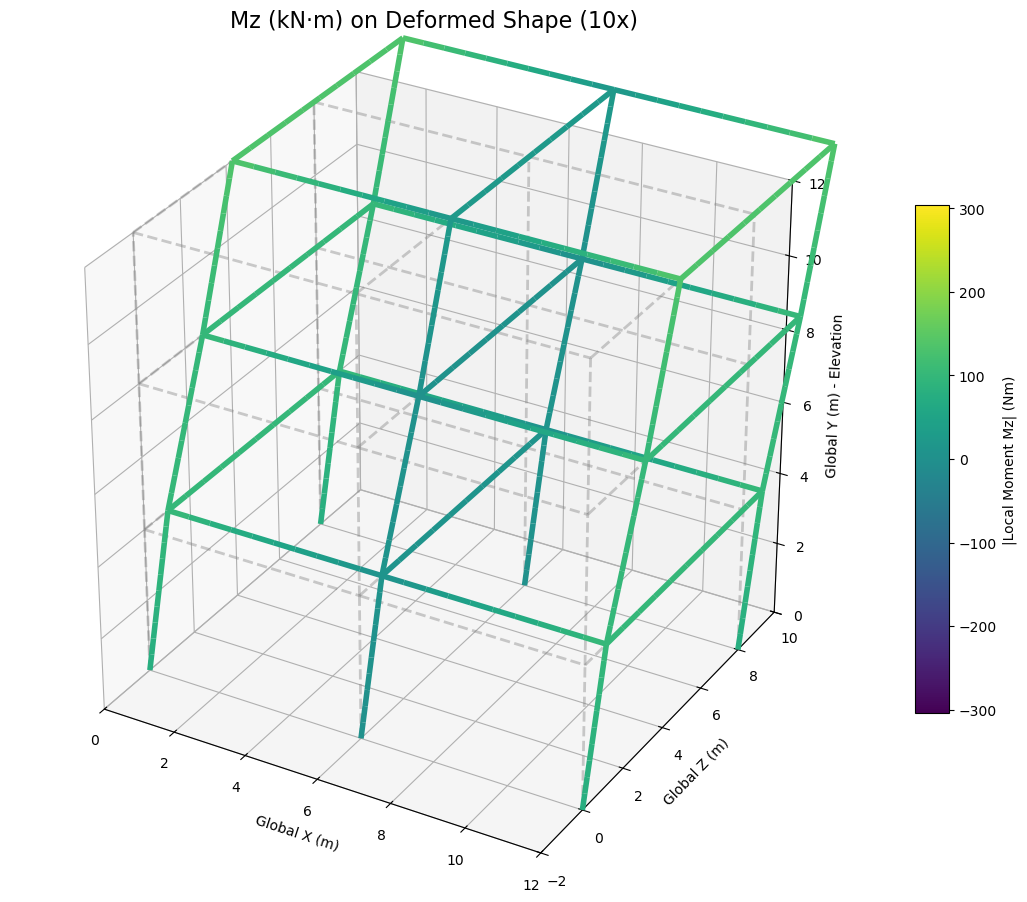

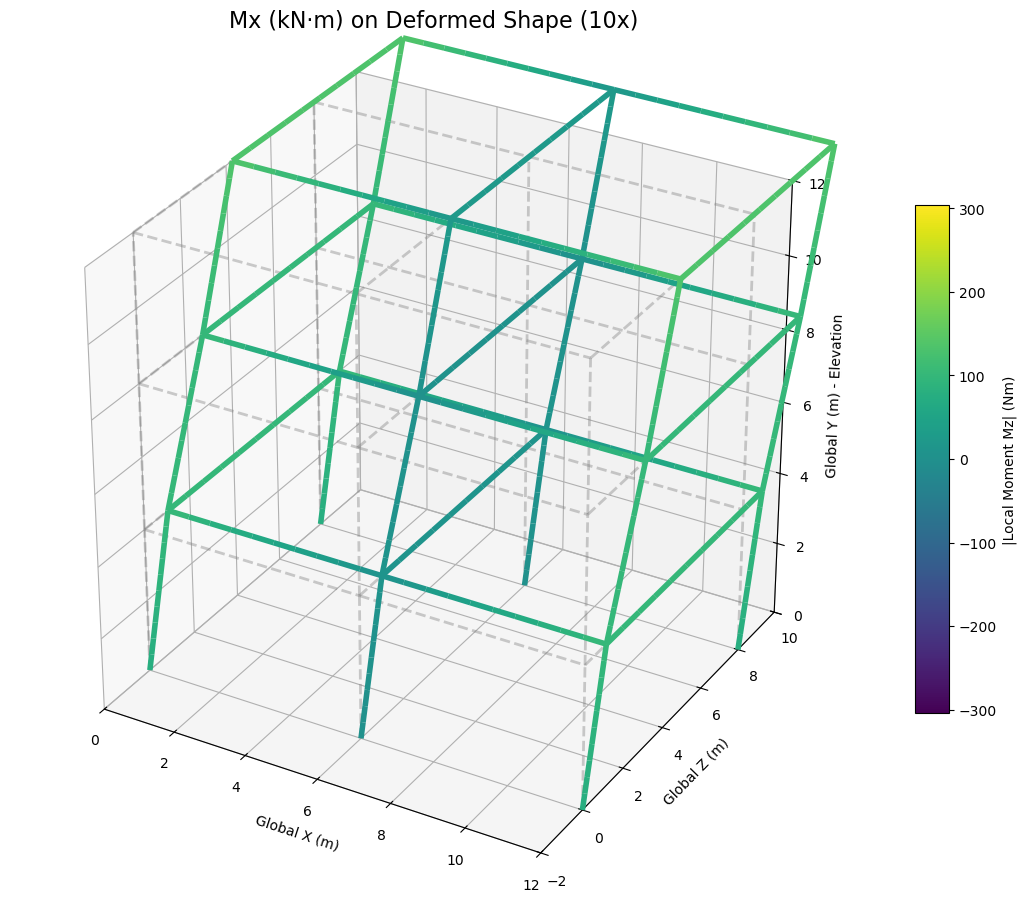

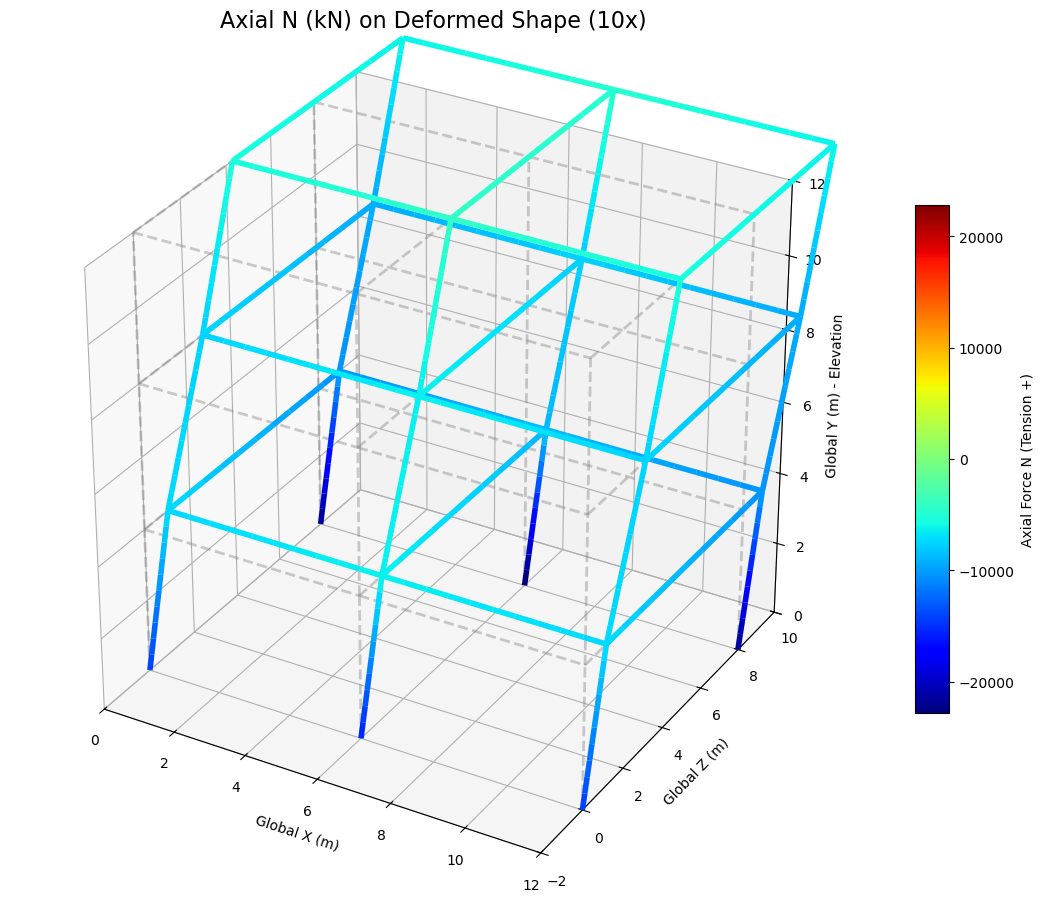

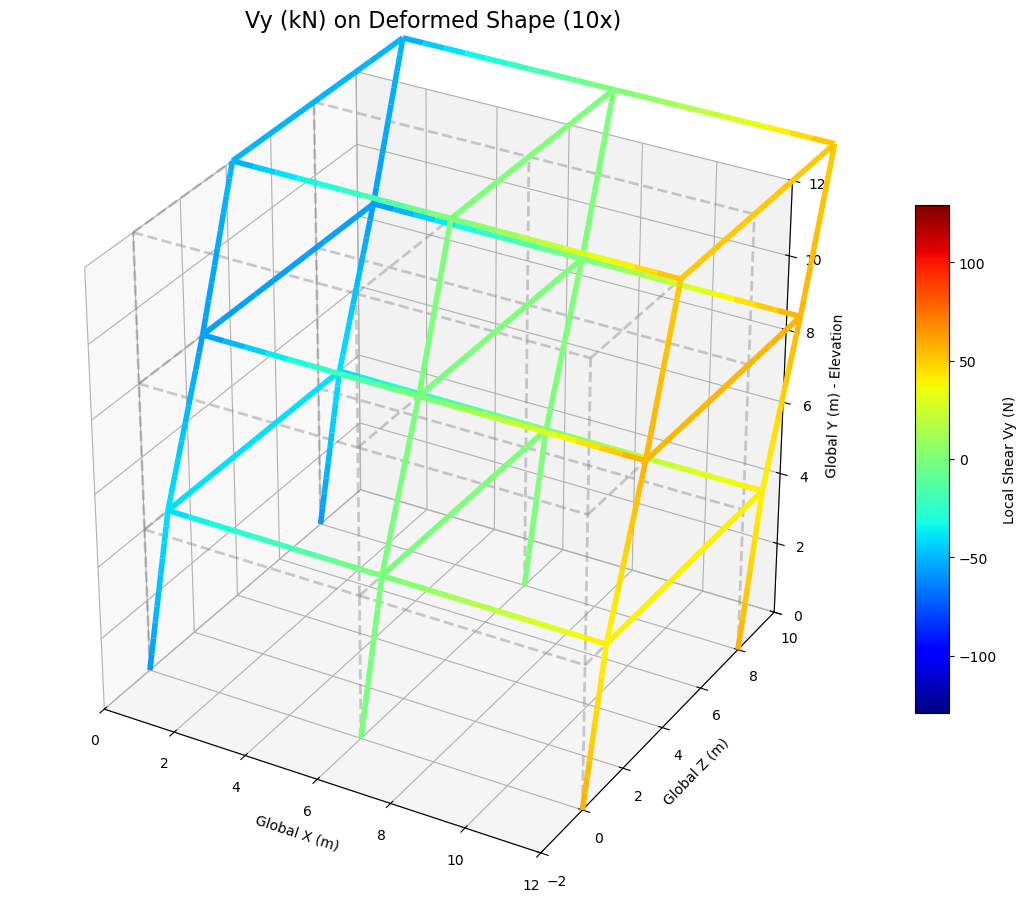

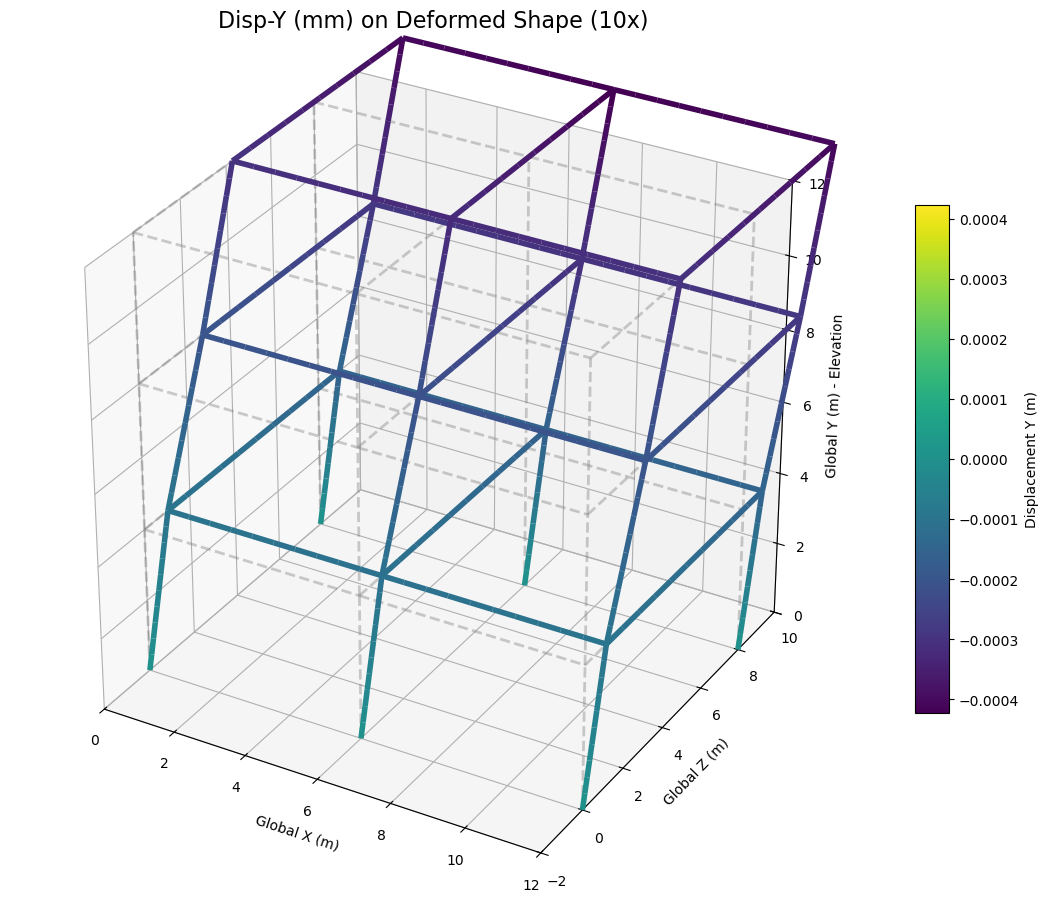

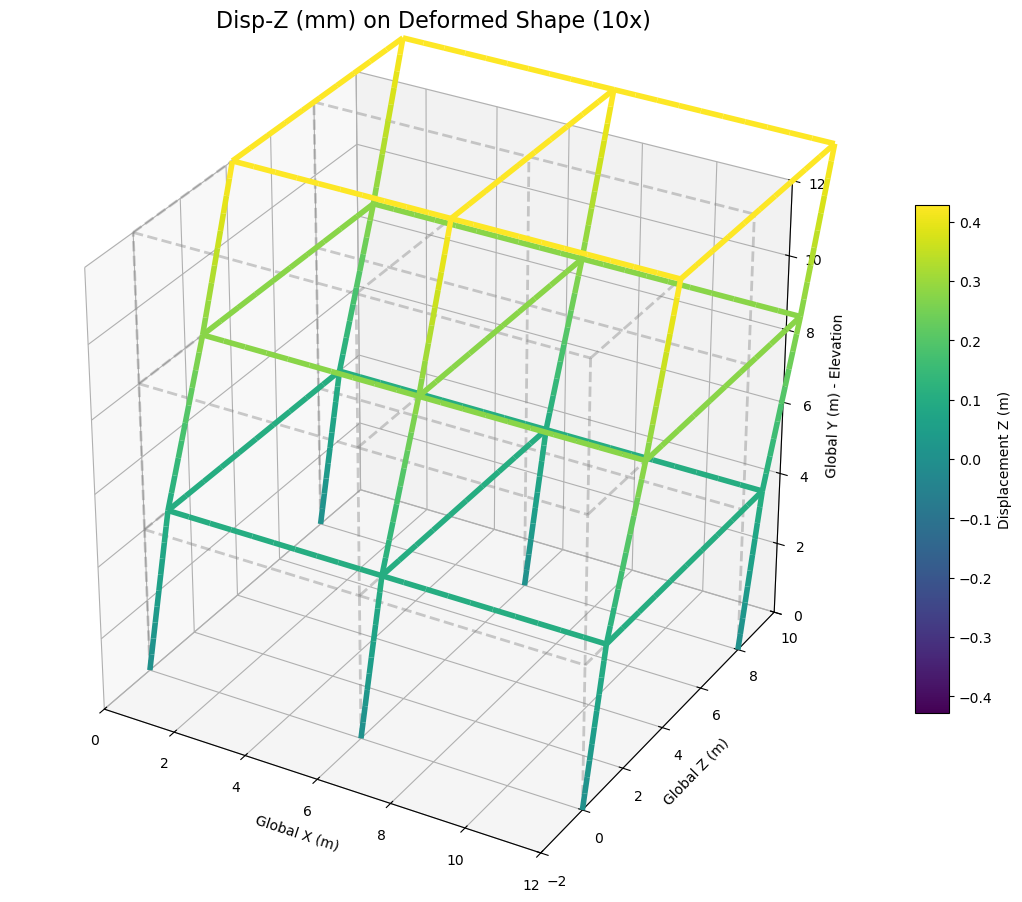

In [7]:
"""
optimise_lightest_frame.py  –  no-grid plotting version
"""

from __future__ import annotations
import numpy as np, pickle, matplotlib.pyplot as plt
from itertools import combinations, product
from pathlib import Path
from time import perf_counter

import profile_manager
from structural_model import Node, Beam, Connection
from frame_analyzer import FrameAnalyzer
from aisc360_verifier import AISC360Verifier
from visualizer import Visualizer

# -------- constants ------------------------------------------------------
DENS_STEEL = 7850.0
E, NU = 2.0e11, 0.30
FY, FU = 355e6, 490e6

N_STORIES, H_STORY = 3, 4.0
BAYS_X, BAYS_Z = [6.0, 6.0], [8.0]
NX, NZ = len(BAYS_X) + 1, len(BAYS_Z) + 1
XPTS, ZPTS = [0.0] + list(np.cumsum(BAYS_X)), [0.0] + list(np.cumsum(BAYS_Z))

P_ROOF   = -150e2     # N
FZ_WIND  =  25e2      # N

# -------- helpers --------------------------------------------------------
def nid(s, ix, iz): return s * (NX * NZ) + iz * NX + ix

def build(col_sh: str, beam_sh: str):
    col_p  = profile_manager.get_beam_properties(col_sh,  E, NU, DENS_STEEL)
    beam_p = profile_manager.get_beam_properties(beam_sh, E, NU, DENS_STEEL)

    nodes = [Node(x, s*H_STORY, z)
             for s in range(N_STORIES+1) for z in ZPTS for x in XPTS]

    beams, attach, bid = [], [[] for _ in nodes], 0
    # columns
    for s in range(N_STORIES):
        for iz in range(NZ):
            for ix in range(NX):
                n1, n2 = nid(s, ix, iz), nid(s+1, ix, iz)
                bm = Beam(n1, n2, **col_p); bm.profile_name = col_sh
                beams.append(bm); attach[n1].append(bid); attach[n2].append(bid); bid += 1
    # floor beams
    for s in range(1, N_STORIES+1):
        for iz in range(NZ):
            for ix in range(NX-1):
                n1, n2 = nid(s, ix, iz), nid(s, ix+1, iz)
                bm = Beam(n1, n2, **beam_p); bm.profile_name = beam_sh
                beams.append(bm); attach[n1].append(bid); attach[n2].append(bid); bid += 1
        for ix in range(NX):
            for iz in range(NZ-1):
                n1, n2 = nid(s, ix, iz), nid(s, ix, iz+1)
                bm = Beam(n1, n2, **beam_p); bm.profile_name = beam_sh
                beams.append(bm); attach[n1].append(bid); attach[n2].append(bid); bid += 1

    conns = [Connection(b1,b2,'rigid')
             for lst in attach if len(lst)>1 for b1,b2 in combinations(lst,2)]

    # loads ---------------------------------------------------------------
    g_vec, g_acc = np.array([0, -1, 0]), -9.81
    tmp = FrameAnalyzer(nodes, beams, conns)
    loads = []
    for i, bm in enumerate(beams):
        tmp._compute_beam_properties(bm)
        sw = bm.rho * g_acc * bm.A
        loc = bm.rotation_matrix @ g_vec
        loads.append({"beam_idx": i, "qy": sw*loc[1], "qz": sw*loc[2]})

    roof_nodes    = [nid(N_STORIES, ix, iz) for iz in range(NZ) for ix in range(NX)]
    facade_nodes  = [nid(s, ix, 0) for s in range(N_STORIES+1) for ix in range(NX)]
    for n in roof_nodes:   loads.append({"node_idx": n, "Fy": P_ROOF})
    for n in facade_nodes: loads.append({"node_idx": n, "Fz": FZ_WIND})

    supports = [{"node_idx": i,
                 "u":0,"v":0,"w":0,"theta_x":0,"theta_y":0,"theta_z":0}
                for i in range(NX*NZ)]

    ana = FrameAnalyzer(nodes, beams, conns)
    if not ana.solve(loads, supports): raise RuntimeError("solve fail")
    mass = sum(bm.A * bm.rho * bm.length for bm in beams)
    return ana, mass

# -------- optimisation loop ---------------------------------------------
def main():
    db = pickle.load(Path("profiles.pkl").open("rb"))
    profile_manager.populate_database(db)

    i_df = next(df for k, df in db.items()
                if k.lower() in ("ipn","ipe","w","wf","i"))
    i_df["kg_m"] = i_df["Peso (kg/m)"].fillna(i_df["Ag (m²)"]*DENS_STEEL)
    shapes = i_df.sort_values("kg_m")["Profile"].str.upper().tolist()

    col_list, beam_list = shapes[:30], shapes[:30]
    min_beam_kgm = i_df.loc[i_df["Profile"].str.upper()==beam_list[0],"kg_m"].iloc[0]

    best_mass, best_pair = float('inf'), None
    print(f"⇢  Evaluating {len(col_list)*len(beam_list):,} combinations\n")
    t0 = perf_counter()

    for col in col_list:
        kgm_col = i_df.loc[i_df["Profile"].str.upper()==col,"kg_m"].iloc[0]
        if 12*H_STORY*kgm_col + 12*6*min_beam_kgm >= best_mass:
            print("↪  further columns cannot beat current best – stopping outer loop")
            break

        for beam in beam_list:
            kgm_beam = i_df.loc[i_df["Profile"].str.upper()==beam,"kg_m"].iloc[0]
            if 12*H_STORY*kgm_col + 12*6*kgm_beam >= best_mass:
                break

            try:
                ana, m_tot = build(col, beam)
                uc_max = AISC360Verifier(ana, db, FY, FU).run()["governing_uc"].max()
                passes = uc_max <= 1.0
                delta  = f"{uc_max-1:+.2f}" if not passes else ""
                new    = ""
                if passes and m_tot < best_mass:
                    best_mass, best_pair, new = m_tot, (col, beam), f"new-best {m_tot:,.0f} kg"
                status = "✓" if passes else "✗"
                print(f"C/{col:<10} B/{beam:<10} UC={uc_max:4.2f} {status} {delta} {new}")
            except Exception as exc:
                print(f"C/{col:<10} B/{beam:<10} ERROR ({exc})")

    print(f"\nSearch completed in {perf_counter()-t0:.1f} s")

    if best_pair is None:
        print("No passing design found."); return

    print(f"\n★ Lightest passing design:"
          f"\n  Columns : {best_pair[0]}"
          f"\n  Beams   : {best_pair[1]}"
          f"\n  Mass    : {best_mass:,.0f} kg")

    # -------- individual plots for the best structure -------------------
    ana_best, _ = build(*best_pair)

    ver_best = AISC360Verifier(ana_best, db, FY, FU)
    uc_table = ver_best.run()

    import pandas as pd                       # tidy console formatting
    pd.set_option("display.max_columns", None)
    print("\nAISC-360-22 unity checks for the optimised structure:")
    print(uc_table.to_string(index=False))
    # uc_table.to_csv('verifies_profiles.csv')

    vis = Visualizer(ana_best)

    # ask for the common set; silently skip those the solver didn’t return
    plot_wishlist = [
        ("moment_z",   "Mz (kN·m)"),
        ("moment_x",   "Mx (kN·m)"),        # might be absent
        ("axial_force","Axial N (kN)"),
        ("shear_y",    "Vy (kN)"),          # might be absent
        ("disp_y",     "Disp-Y (mm)"),
        ("disp_z",     "Disp-Z (mm)")
    ]

    print("\nGenerating result plots...")
    for rtype, title in plot_wishlist:
        try:
            vis.plot_deformed_shape(result_type=rtype, title=title, amplification_factor=10)
        except (IndexError, KeyError, ValueError) as e:
            # IndexError → beam_end_vals missing
            # KeyError/ValueError → visualizer doesn't recognise rtype
            print(f"  – Skipped '{rtype}': {e}")

# ------------------------------------------------------------------------
if __name__ == "__main__":
    main()
